# グラフ彩色問題
このチュートリアルでは、量子近似最適化アルゴリズム（QAOA）を用いてグラフ彩色問題を解きます。

まず、使用する主要なライブラリをインストールし、インポートしましょう。

In [1]:
# !pip install qamomile[qiskit, quri_parts]

In [2]:
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ommx.v1
import qiskit.primitives as qk_pr
import scipy.optimize as opt

import qamomile.core as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.qiskit import QiskitTranspiler

## 数理モデルの構築
まず、`JijModeling` を用いてグラフ彩色問題の数学モデルを実装します。

In [3]:
def graph_coloring_problem() -> jm.Problem:
    # 変数を定義する
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # 問題を設定する
    problem = jm.Problem("Graph Coloring")
    # 各頂点がちょうど1つの色を持つようにする one-hot 制約を設定する
    problem += jm.Constraint("one-color", x[v, :].sum() == 1, forall=v)
    # エッジでつながれた頂点が同じ色になる数を最小化する目的関数を設定する
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

problem = graph_coloring_problem()
problem

## インスタンスデータの準備
次に、この問題のインスタンスを作成します。

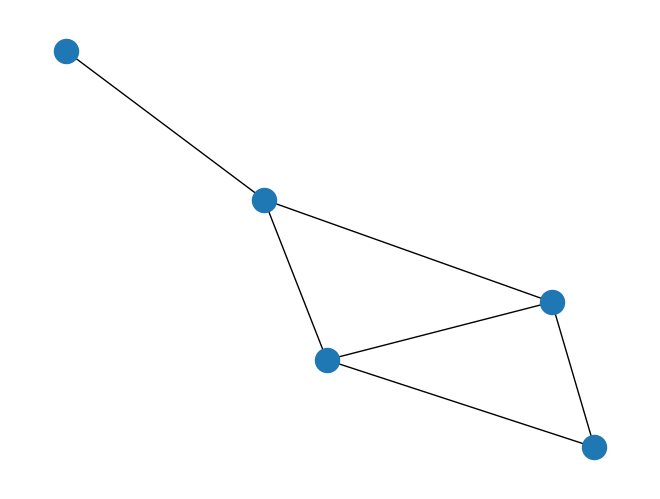

In [4]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3), (3, 4), (2, 4)])
nx.draw(G)

In [5]:
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

## コンパイル済みインスタンスの作成
では、QAOAを用いてグラフ彩色問題を解いてみましょう。  
QAOAを実行するには、数理モデルをイジングハミルトニアンに変換し、  
量子計算ライブラリを使って変分量子回路とハミルトニアンを作成する必要があります。  
しかし、`Qamomile`はQAOAをサポートしており、比較的簡単に実行できます。

まず、`JijModeling.Interpreter`を用いて、`JijModeling`の数理モデルとインスタンスデータから`ommx.Instance`を作成します。

In [6]:
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)

## Qamomileを用いたQAOA回路とハミルトニアンの生成
次に、`QAOAConverter`を作成します。  
このConverterに制約に対する重みを設定することで、ハミルトニアンを作成できます。

In [7]:
qaoa_converter = qm.qaoa.QAOAConverter(instance)
qaoa_converter.ising_encode(multipliers={"one-color": 5})
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=1)
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

## QAOA 回路の可視化

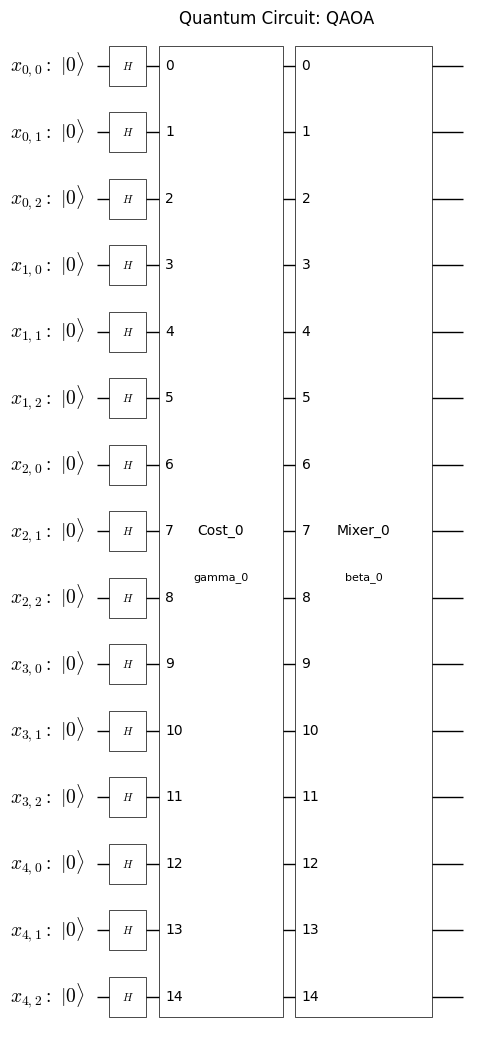

In [8]:
plot_quantum_circuit(qaoa_circuit)

## 取得した QAOA 回路とハミルトニアンを Qiskit 向けに変換

変分量子回路とハミルトニアンの準備が整ったので、実際にQiskitを用いてQAOAを実行してみましょう。  
Qamomile の回路を Qiskit の回路に変換し、シミュレーションを実行します。

In [9]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_cost = qk_transpiler.transpile_hamiltonian(qaoa_cost)

## QAOA の実行

In [10]:
# 変分ステップ
estimator = qk_pr.StatevectorEstimator()

cost_history = []
def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data['evs']
    cost_history.append(cost)
    return cost

result = opt.minimize(estinamate_cost, [0, 0], method="COBYLA", options={"maxiter": 1000})
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 28.252167958276864
       x: [ 1.248e+00 -2.628e-01]
    nfev: 295
   maxcv: 0.0

## 結果の可視化

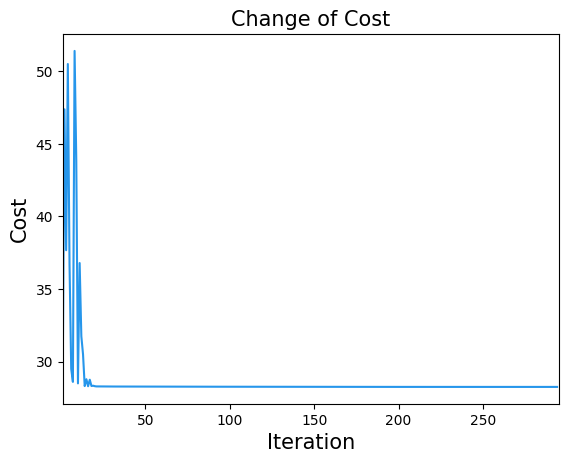

In [11]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [12]:
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
plt.show()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()

In [13]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result[0].data['meas'])

## 解のプロット

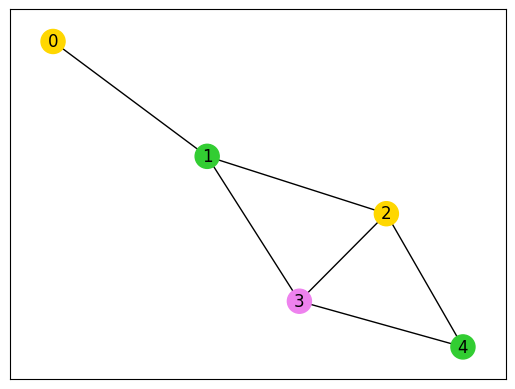

In [14]:
def plot_graph_coloring(graph: nx.Graph, sampleset: ommx.v1.SampleSet):
    # extract feasible solution
    feasibles = [feas for feas in sampleset.feasible.values() if feas]
    if len(feasibles) == 0:
        print("No feasible solution found ...")
    else:
        lowest_sample = sampleset.best_feasible_unrelaxed()

        # get indices of x = 1
        indices = [subscripts for subscripts, value in lowest_sample.extract_decision_variables("x").items() if value == 1]
        # get vertices and colors
        # initialize vertex color list
        node_colors = [-1] * graph.number_of_nodes()
        # set color list for visualization
        colorlist = ["gold", "violet", "limegreen", "darkorange"]
        # set vertex color list
        for i, j in indices:
            node_colors[i] = colorlist[j]
        # make figure
        nx.draw_networkx(graph, node_color=node_colors, with_labels=True)
        plt.show()

# Visualize the graph coloring result
plot_graph_coloring(G, sampleset)